#### 파이프라인?
```
데이터 전처리, 특성 추출, 모델학습을 하나의 흐름으로 연결
```
#### 사용이유
```
코드 간결화 : 여러단계를 하나로 묶어서 관리
재현성 보장 : 전체 ㅍ로세스를 일관되게 실행
데이터 누수 방지 : 교차 검증시 각 fold에서 독립적으로 전처리
하이퍼 파라메터 튜닝 용이 : 전체 파이프라인에 대해서 그리드서치 적용
```
#### 파이프라인 구성요소
````
변환기
    데이터를 변환하는 객체
    fit() : 데이터에서 파라메터를 학습
    transform() : 학습파라메터로  데이터를 변환
    StandardScaler, PCA, MinMaxScaler
추정기
    머신러닝 모델
    fit() : 데이터로 모델을 학습
    predict() : 예측 수행
    RandomForest, SVM ... 
````
#### 데이터 : 위스콘시 유방암 데이터  대표적인 이진분류 데이터
````
클래스 2(양성 악성)
특성 : 10개
````

In [84]:
# 파이프 라인 구성
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression # 각 클래스에 대한 확률값을 출력 이후 이 확률값이 큰 클래스가 선택 결국 분류 모델

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('classifier', LogisticRegression())
])

#### 파이프라인 실행ㄱ과정
````
pipe.fit(x_train, y_train)
StandardScaler x_train에 fit --> 평균과 표준편차 계산
x_train 을 표준화 x_scaled
PCA가 x_scaled fit -> 주성분 계산
x_scaled 변환 x_pca
LogisticRegression 이 x_pca fit
````

#### 데이터 누수 방지
````
잘못된 예
전체 데이터를 먼저 스케일링
x_scaled = scaler.fit_transform(x)
x_train, x_test = train_test + split(x_scaled)
model.fit(x_train, y_train)
````
문제 --> 데스트 데이터 정보가 스케일에 사용
````
올바른 예
학습데이터만으로 스케일링
x_train, x_test = train_test_split(x)
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test) # fit 없이 transform만 !!!
model.fit(x_train_scaled, y_train)
````

#### 파이프라인 사용(best)
````
pipe.fit(x_train, y_train)  #학습 데이터만 fit
pipe.predict(x_test) # 테스트데이터는 transform만
````

#### 교차검증... k-겹
````
홀드아웃 : 데이터를 학습세트 테스트 세트 한번만 분할
전체데이터 100%
    학습 70 ~ 80%
    데스트 20 ~ 30%
장점 : 
    빠르다
    대용량 데이터에 적합
단점 : 
    데이터 분할에 따라서 성능이 크게 달라질수 있음
    작은 데이터셋 불안
    일부 데이터만 학습에 사용
언제사용 : 
    데이터가 충분히 많을 때(수만개 이상)
    빠르게 평가할때
````

````
k-겹 교차검증(k-fold Cross-Validation)
````

#### k-fold
````
일반 k-fold
층화 Stratified k-fold
````

#### 학습곡선과 검증 곡선
````
학습 데이터 크기에 따른 모델 성능을 시각화
````

#### 그리드 서치를 사용한 머신러닝 모델 세부 튜닝
````
하이퍼파라메터
    파라메터 : 학습으로 찾음
        선형회귀 계수, 신경망의 가중치
        ...

    하이퍼 파라메터 : 사람이 설정
        학습률
        정규화
        트리의 깊이
        ...

그리드서치 : 모든 가능한 조합으로 체계적으로 시도
param_grid = {
    'max_depth' : [3,5,...],
    ...
}

랜덤그리드 서치 : 모든 가능한 조합을 랜덤
    더 넓은 영역을 탐색 - 파라메터의 조합의 경우의 수
    시간제약이 있을때
언제 사용
    그리드 서치 : 하이퍼 파라메터가 2~3개
    랜덤서치 : 하이퍼 파라메터가 4개 이상

그리드 서치(각 3개 값)
A : 3개의 고유값
B : 3개의 고유값
랜덤서치(9번 시도)
서로다른 최대 9개의 값으로 시도
중요한 파라메터에  더 많은 시도

````

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings('ignore')

In [86]:
# section 1 : 위스콘신 유방암 데ㅔ이터셋 로드 및 탐색
def section1_load_data():
    """
    데이터셋 구조 이해
    특성과 타겟의 관계 파악
    클래스 분포 확인
    """
    print("section 1 : 위스콘신 유방암 데이터셋")

    # 데이터 로드
    data = load_breast_cancer()
    X, y = data.data, data.target
    print("데이터셋 기본정보")
    print(f'샘플 수 : {X.shape[0]}, 특성 수 : {X.shape[1]}')
    print(f'클래스 : {data.target_names}')
    # 클래스 분포
    unique, counts = np.unique(y, return_counts=True)
    print("클래스 분포")
    for u, c in zip(unique, counts):
        class_name = data.target_names[u]
        percentage = c / len(y)*100
        print(f'클래스 {class_name} : {c} 샘플 ({percentage:.1f}%)')
    # 특성 통계
    print("특성 통계 (처음 5개 특성)")
    for  i in range(5):
        print(f'{data.feature_names[i]} - 평균: {np.mean(X[:, i]):.2f}, 표준편차: {np.std(X[:, i]):.2f}, 최소값: {np.min(X[:, i]):.2f}, 최대값: {np.max(X[:, i]):.2f}')
    return X, y, data



In [95]:
X, y, data = section1_load_data()

section 1 : 위스콘신 유방암 데이터셋
데이터셋 기본정보
샘플 수 : 569, 특성 수 : 30
클래스 : ['malignant' 'benign']
클래스 분포
클래스 malignant : 212 샘플 (37.3%)
클래스 benign : 357 샘플 (62.7%)
특성 통계 (처음 5개 특성)
mean radius - 평균: 14.13, 표준편차: 3.52, 최소값: 6.98, 최대값: 28.11
mean texture - 평균: 19.29, 표준편차: 4.30, 최소값: 9.71, 최대값: 39.28
mean perimeter - 평균: 91.97, 표준편차: 24.28, 최소값: 43.79, 최대값: 188.50
mean area - 평균: 654.89, 표준편차: 351.60, 최소값: 143.50, 최대값: 2501.00
mean smoothness - 평균: 0.10, 표준편차: 0.01, 최소값: 0.05, 최대값: 0.16


In [88]:
# section 2 : 파이프라인 기본 사용법
def section2_basic_pipeline(X, y):
    """
    - pipeline 객체  생성
    - 표준화 + 모델 학습을  한번에 수행
    - 파이프라인의 장점을 이해
    """
    # 데이터 분할
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    # 수동방식
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    lr = LogisticRegression(random_state=42, max_iter=1000)
    lr.fit(x_train_scaled, y_train)
    manual_score = lr.score(x_test_scaled, y_test)
    print("수동 방식 사용")
    print(f"학습세트 크기 : {x_train.shape[0]}")
    print(f'테스트세트 크기 : {x_test.shape[0]}')
    print(f'테스트세트 정확도 : {manual_score:.4f}')

    print('*' * 100)
    print("파이프라인 사용")
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ])
    pipe.fit(x_train, y_train)
    pipe_score = pipe.score(x_test, y_test)
    print('파이프라인구조')
    for name, step in pipe.steps:
        print(f'{name} : {step.__class__.__name__}')

    print(f'테스트 정확도 : {pipe_score:.4f}')
    print(f'수동방식과 동일한 결과 : {np.isclose(manual_score, pipe_score)}')




In [89]:
section2_basic_pipeline(X, y)

수동 방식 사용
학습세트 크기 : 398
테스트세트 크기 : 171
테스트세트 정확도 : 0.9883
****************************************************************************************************
파이프라인 사용
파이프라인구조
scaler : StandardScaler
classifier : LogisticRegression
테스트 정확도 : 0.9883
수동방식과 동일한 결과 : True


In [90]:
# 교차 검증 비교(홀드아웃 vs k-겹)
def section3_cross_validation(x,y):
    """
    - 홀드아웃의 한계
    - k-겹 교차 검증 장점
    - 층화 k-겹의 중요성
    """
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ])
    # 여러번 반복해서 불안정성 확인
    holdout_scores = []
    for i in range(10):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=i)
        pipe.fit(x_train, y_train)
        score = pipe.score(x_test, y_test)
        holdout_scores.append(score)
        # 처음 3개만 출력
        if i < 3:
            print(f'홀드아웃 반복 {i+1} - 테스트 정확도: {score:.4f}')
    print("---")
    print(f'홀드아웃 평균 : {np.mean(holdout_scores):.4f}, 표준편차 : {np.std(holdout_scores):.4f}')
    print(f'min : {np.min(holdout_scores):.4f}, max : {np.max(holdout_scores):.4f}')

    # 5-겹 교차 검증
    cv_scores = cross_val_score(pipe, x, y, cv=5, scoring='accuracy')
    print('각 Fold의 점수')
    for i, score in enumerate(cv_scores, 1):
        print(f'Fold {i} - 정확도: {score:.4f}')
    print(f'교차검증 평균 : {np.mean(cv_scores):.4f}, 표준편차 : {np.std(cv_scores):.4f}')

    print('-'*100)
    # 층화 k-겹 교차 검증
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    stratified_scores = cross_val_score(pipe, x, y, cv=skf, scoring='accuracy')
    print('각 Fold의 점수')
    for i, score in enumerate(stratified_scores, 1):
        print(f'Fold {i} - 정확도: {score:.4f}')
    print(f'교차검증 평균 : {np.mean(stratified_scores):.4f}, 표준편차 : {np.std(stratified_scores):.4f}')

    # 각 fold의 클래스 분포 확인
    for i, (train_index, test_index) in enumerate(skf.split(x, y), 1):
        y_fod = y[test_index]
        unique, counts = np.unique(y_fod, return_counts=True)
        ratio = counts[1] / len(y_fod) * 100
        print(f'Fold {i} : 악성 {ratio:.1f}%')

    print('결론')
    print(f'홀드아웃 : 분할에  따라 성능차이가 큼 : {np.std(holdout_scores):.4f}')
    print(f'k-겹 : 더 안정적인 추정 : {np.std(cv_scores):.4f}')
    print(f'층화 k-겹 : 클래스 비율유지로  더 신뢰성 있음')


section3_cross_validation(X, y)

홀드아웃 반복 1 - 테스트 정확도: 0.9766
홀드아웃 반복 2 - 테스트 정확도: 0.9708
홀드아웃 반복 3 - 테스트 정확도: 0.9708
---
홀드아웃 평균 : 0.9766, 표준편차 : 0.0074
min : 0.9649, max : 0.9883
각 Fold의 점수
Fold 1 - 정확도: 0.9825
Fold 2 - 정확도: 0.9825
Fold 3 - 정확도: 0.9737
Fold 4 - 정확도: 0.9737
Fold 5 - 정확도: 0.9912
교차검증 평균 : 0.9807, 표준편차 : 0.0065
----------------------------------------------------------------------------------------------------
각 Fold의 점수
Fold 1 - 정확도: 0.9737
Fold 2 - 정확도: 0.9474
Fold 3 - 정확도: 0.9649
Fold 4 - 정확도: 0.9912
Fold 5 - 정확도: 0.9912
교차검증 평균 : 0.9737, 표준편차 : 0.0166
Fold 1 : 악성 62.3%
Fold 2 : 악성 62.3%
Fold 3 : 악성 63.2%
Fold 4 : 악성 63.2%
Fold 5 : 악성 62.8%
결론
홀드아웃 : 분할에  따라 성능차이가 큼 : 0.0074
k-겹 : 더 안정적인 추정 : 0.0065
층화 k-겹 : 클래스 비율유지로  더 신뢰성 있음


In [112]:
# 섹션 4 : 학습 곡선으로 편향-분산 분석
def section4_learning_curves(X,y):
    """
    - 학습곡선
    - 과소적합 / 과대적합 판단
    - 데이터 추가 필요성 판단
    """
    print('다양한 모델의 학습곡선 비교')
    models = [
        ('underfit\n(simple model)', 
         Pipeline([('sacler',StandardScaler()),('clf',LogisticRegression(C=0.01,max_iter = 1000))]) ),  # C는 규제강도

        ('normal\n(basic model)', 
         Pipeline([('sacler',StandardScaler()),('clf',LogisticRegression(C=1.0,max_iter = 1000))]) ),

        ('small overfit \n(complex model)', 
         Pipeline([('sacler',StandardScaler()),('clf',SVC(kernel='rbf',gamma='auto'))]) ),

        ('overfit\n(strong complex model)', 
         Pipeline([('sacler',StandardScaler()),('clf',DecisionTreeClassifier())]) ),
    ]
    fig, axes  = plt.subplots(2, 2, figsize=(15, 10))
    for idx, (title, model) in enumerate(models):
        ax = axes[idx // 2, idx % 2]
        # 학습곡선 계산
        train_sizes, train_scores, test_scores = learning_curve(
            model, X, y, cv=5,
            train_sizes=np.linspace(0.1, 1.0, 10),
            scoring='accuracy',
            n_jobs=-1,
        )
        # 평균과 표준편차 계산
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        # 그래프 그리기
        ax.plot(train_sizes,train_mean, label='train score', marker='o', color='blue')
        ax.fill_between(train_sizes, train_mean - train_std, train_mean+train_std, alpha=0.15, color='blue')

        ax.plot(train_sizes,test_mean, label='test score', marker='s', color='red')
        ax.fill_between(train_sizes, test_mean - test_std, test_mean+test_std, alpha=0.15, color='red')

        ax.set_xlabel('train sample counts', fontsize=10)
        ax.set_ylabel('accuracy', fontsize=10)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0.5,1.05])

        # 최종성능 출력
        final_train =  train_mean[-1]
        final_test =  test_mean[-1]
        gap = final_train - final_test
        print(f'{title} - 최종 학습 정확도: {final_train:.4f}, 최종 테스트 정확도: {final_test:.4f}, 격차: {gap:.4f}')

        if gap < 0.05 and final_test < 0.85:
            print("진단 : 과소적합(높은 편항)")
            print('해결책 : 더 복잡한 모델 사용')
        elif gap > 0.15:
            print('진단 : 과대적합(높은 분산)')
            print('해결책 : 더 간단한 모델 사용')
        else:
            print('진단 : 적절한 모델')

다양한 모델의 학습곡선 비교
underfit
(simple model) - 최종 학습 정확도: 0.9556, 최종 테스트 정확도: 0.9491, 격차: 0.0065
진단 : 적절한 모델
normal
(basic model) - 최종 학습 정확도: 0.9895, 최종 테스트 정확도: 0.9807, 격차: 0.0088
진단 : 적절한 모델
small overfit 
(complex model) - 최종 학습 정확도: 0.9873, 최종 테스트 정확도: 0.9736, 격차: 0.0136
진단 : 적절한 모델
overfit
(strong complex model) - 최종 학습 정확도: 1.0000, 최종 테스트 정확도: 0.9103, 격차: 0.0897
진단 : 적절한 모델


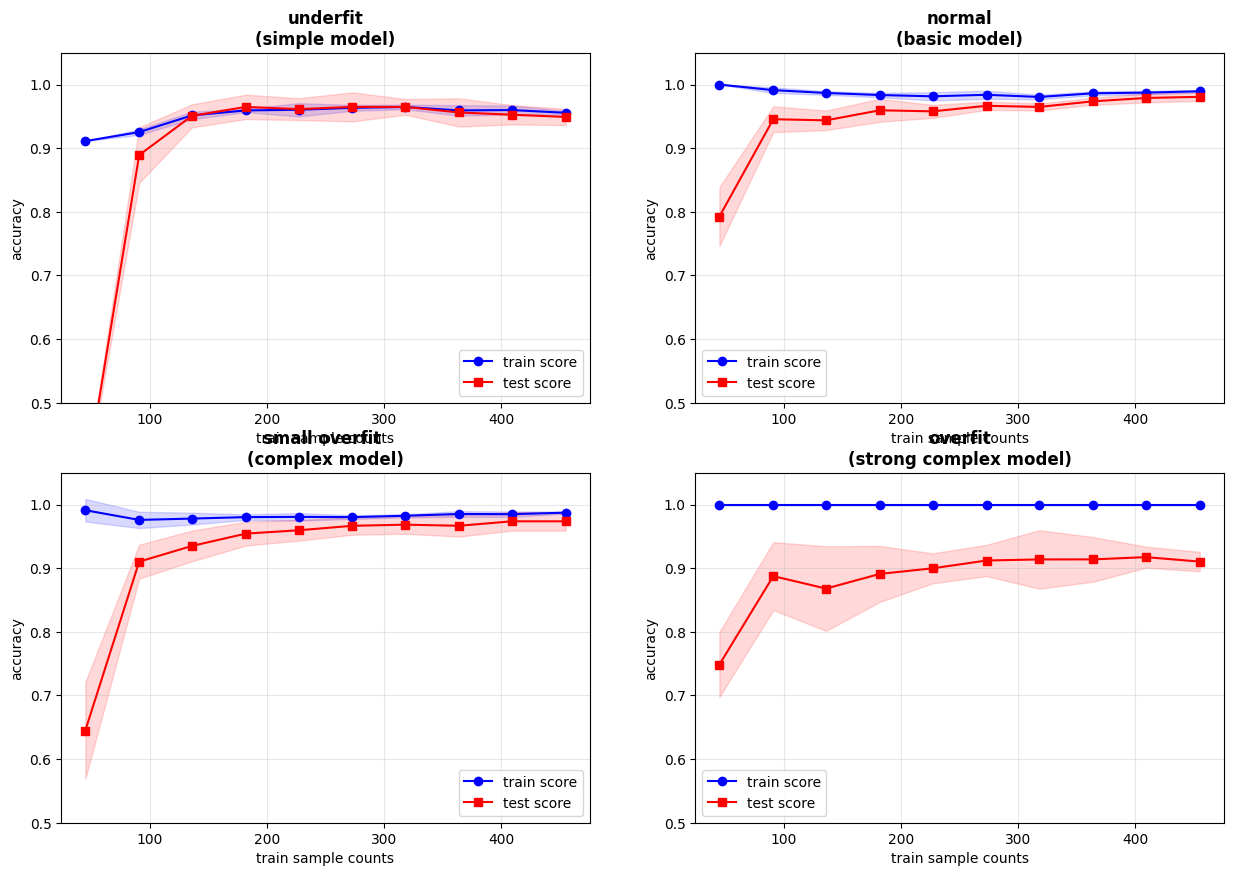

In [113]:
section4_learning_curves(X, y)

In [117]:
# 검증 곡선으로 하이퍼 파라메터 분석
def section5_validation_curve(X,y):
    """
    - 검증 곡선
    - 최적 하이퍼파라메터 범위 확인
    - 과대 / 과소 적합 구간 확인
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    # Logistic Regression C 파라메터
    print('Logistic Regression 정규화 파라메터 (C) 검증 곡선')
    print('( C 가 적을수록 강한 정규화 )')

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000))
    ])
    param_range = np.logspace(-4, 4, 9)  #0.0001 부터 10000 까지
    train_scores, test_scores = validation_curve(
        pipe, X, y,
        param_name='clf__C',
        param_range=param_range,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    # 평균과 표준편차
    train_mean = train_scores.mean(axis=1)
    train_std =  train_scores.std(axis=1)
    test_mean = test_scores.mean(axis=1)
    test_std = test_scores.std(axis=1)

    # 그래프 그리기  semilogx x축을 로그 스케일로 설정해서 선 을 그리는 함수  작은값부터 큰 값까지 폭 넒게 분포된 값을 시각화
    ax[0].semilogx(param_range,train_mean, label='train score', marker='o', color='blue')
    ax[0].fill_between(param_range, train_mean - train_std, train_mean+train_std, alpha=0.15, color='blue')

    ax[0].semilogx(param_range,test_mean, label='test score', marker='s', color='red')
    ax[0].fill_between(param_range, test_mean - test_std, test_mean+test_std, alpha=0.15, color='red')

    ax[0].set_xlabel('Parameter C', fontsize=10)
    ax[0].set_ylabel('accuracy', fontsize=10)
    ax[0].set_title("logistic regression C ", fontsize=12, fontweight='bold')
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)  

    # 최적의 값
    best_idx = np.argmax(test_mean)  
    best_c = param_range[best_idx]
    best_score = test_mean[best_idx]

    print(f'최적의 C : {best_c:.4f}')
    print(f'최고 검증 점수는 : {best_score:.4f}')

    # Decision Tree max_depth 파라메터

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', DecisionTreeClassifier())
    ])
    param_range = range(1,21)
    train_scores, test_scores =  validation_curve(
        pipe,X,y,
        param_name='clf__max_depth',
        param_range= param_range,
        cv=5,
        scoring='accuracy'  ,
        n_jobs = -1
    )
    # 평균과 표준편차
    train_mean = train_scores.mean(axis=1)
    train_std =  train_scores.std(axis=1)
    test_mean = test_scores.mean(axis=1)
    test_std = test_scores.std(axis=1)

    # 그래프 그리기  semilogx x축을 로그 스케일로 설정해서 선 을 그리는 함수  작은값부터 큰 값까지 폭 넒게 분포된 값을 시각화
    ax[1].semilogx(param_range,train_mean, label='train score', marker='o', color='blue')
    ax[1].fill_between(param_range, train_mean - train_std, train_mean+train_std, alpha=0.15, color='blue')

    ax[1].semilogx(param_range,test_mean, label='test score', marker='s', color='red')
    ax[1].fill_between(param_range, test_mean - test_std, test_mean+test_std, alpha=0.15, color='red')

    ax[1].set_xlabel('Parameter max_depth', fontsize=10)
    ax[1].set_ylabel('accuracy', fontsize=10)
    ax[1].set_title("logistic regression max_depth ", fontsize=12, fontweight='bold')
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)  

    # 최적의 값
    best_idx = np.argmax(test_mean)  
    best_c = param_range[best_idx]
    best_score = test_mean[best_idx]

    print(f'최적의 max_depth : {best_c:.4f}')
    print(f'최고 검증 점수는 : {best_score:.4f}')   

Logistic Regression 정규화 파라메터 (C) 검증 곡선
( C 가 적을수록 강한 정규화 )
최적의 C : 1.0000
최고 검증 점수는 : 0.9807
최적의 max_depth : 2.0000
최고 검증 점수는 : 0.9280


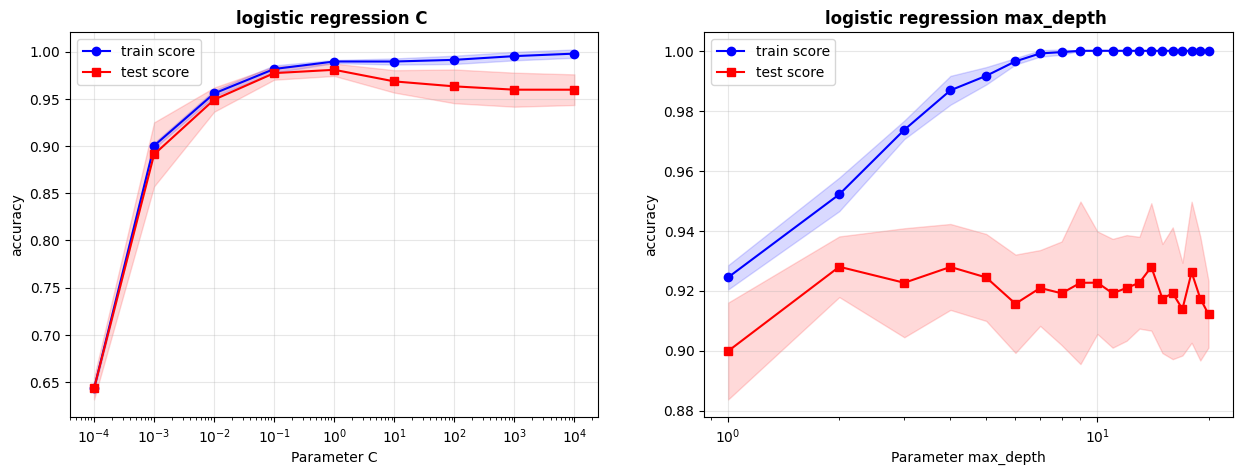

In [118]:
section5_validation_curve(X, y)